<a href="https://colab.research.google.com/github/warenya/OP-GSP-Image-Stitching/blob/main/TIRS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python-headless numpy scipy matplotlib
import cv2
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import math

## オーバーラップ率の計算
グランドサンプリング距離、中心座標、2つ目の画像のField of Viewの頂点、オーバーラップ点、オーバーラップ率はこの関数で計算される。

点A、B、C、D、E、p1, p2, n1、n2, l1, l2 は次の画像に対応している：

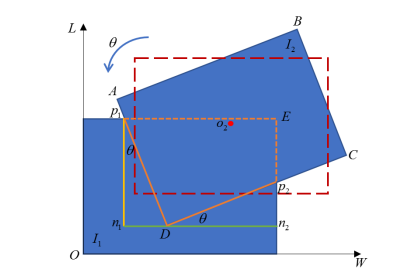

In [ ]:
# オーバーラップ率を計算する関数
def overlap_ratio_calculation(image1, image2, h, f, pixel_size, row, col, lat1, lat2, lon1, lon2, R, uav_pos):
    # 地上サンプリング距離とFOVの計算
    GSD = (h * pixel_size) / f
    w = GSD * col
    l = GSD * row

    # 中心座標の算出
    R = 6378000 #100の位を四捨五入した地球の半径。
    x0 = ((R * math.cos(math.radians(lat1))) * (lon2 - lon1) * math.pi / 180) + w / 2
    y0 = (R * (lat2 - lat1) * math.pi / 180) + l / 2

     # UAVの向きをラジアンに変換
    theta = math.radians(uav_pos)

    # 同次座標を用いた回転変換
    # 変換行列（アフィン変換）
    rotation_matrix = np.array([
        [math.cos(theta), -math.sin(theta), -x0 * math.cos(theta) + y0 * math.sin(theta) + x0],
        [math.sin(theta),  math.cos(theta), -x0 * math.sin(theta) - y0 * math.cos(theta) + y0],
        [0, 0, 1]
    ])

    # 回転前の2つ目の画像のFOVの4隅のダミー値
    corners = np.array([
    [-w/2 + x0,  l/2 + y0,  1],  #頂点A(左上)
    [ w/2 + x0,  l/2 + y0,  1],  #頂点E(右上)
    [ w/2 + x0, -l/2 + y0,  1],  #頂点n2 (右下)
    [-w/2 + x0, -l/2 + y0,  1]   #頂点n1 (左下)
    ]).T

     # 変換を適用する
    transformed_corners = np.dot(rotation_matrix, corners)

   # 変換された座標を取り出す
    xA, yA = transformed_corners[0, 0], transformed_corners[1, 0]
    xB, yB = transformed_corners[0, 1], transformed_corners[1, 1]
    xC, yC = transformed_corners[0, 2], transformed_corners[1, 2]
    xD, yD = transformed_corners[0, 3], transformed_corners[1, 3]

     # オーバーラップ点p1とp2を計算する。
    p1_x = ((l - yD) * (xA - xD) / (yA - yD)) + xD
    p1_y = l
    p2_x = w
    p2_y = ((w - xD) / (xC - xD) * (yC - yD)) + yD

    #間のユークリッド距離：
    mag_p1E =  np.linalg.norm(np.array([p1_x, p1_y]) - np.array([w/2, l/2])) #P1 と E
    mag_p1n1 = np.linalg.norm(np.array([p1_x, p1_y]) - np.array([-w/2, -l/2])) #p1 と n1
    mag_p1D = np.linalg.norm(np.array([p1_x, p1_y]) - np.array([xD, yD])) #p1 と D
    mag_p2D = np.linalg.norm(np.array([p2_x, p2_y]) - np.array([xD, yD])) #p2 と D
    mag_Dn2 = np.linalg.norm(np.array([xD, yD]) - np.array([w/2, -l/2])) #D と n2

    # Return オーバーラップ率
    overlap_ratio = ((mag_p1E * mag_p1n1) - (0.5 * mag_p1n1 * (mag_p1D * math.sin(theta))) -(0.5 * mag_Dn2 * (mag_p2D * math.sin(theta)))) /(p1_y * p2_x)
    return overlap_ratio

##フィーチャーマッチング
TこれはOP-GSP法のステップ2であり、1つの画像からの特徴が2つ目の画像と比較され、マッチングされる。

```
#
  //-- ロウ比テスト**
   {
        if (knn_matches[i][0].distance < ratio_thresh * knn_matches[i][1].distance)
        {
            good_matches.push_back(knn_matches[i][0]);
        }
    }

```




In [ ]:
def feature_matching(img1, img2):
    # SIFT 検出器の初期化
    sift = cv2.SIFT_create()

    # キーポイントを検出し、ディスクリプタを計算する。
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

    # 両方の画像にキーポイントがあるかチェックする。
    if len(keypoints1) == 0 or len(keypoints2) == 0:
        raise ValueError("No keypoints detected in one or both images.")

    # FLANNベースのマッチャーのパラメータ
    # チェック値が高いほど精度が上がるが、スピードは遅くなる
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    # FLANNベースのマッチャー
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # KNN (K-Nearest Neighbors) を用いた記述子のマッチング
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    # ロウの比率テストを適用して、良い一致をフィルターする
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    if len(good_matches) == 0:
        raise ValueError("No valid matches found between images.")

    # マッチした点を抽出する
    points1 = np.array([keypoints1[m.queryIdx].pt for m in good_matches])
    points2 = np.array([keypoints2[m.trainIdx].pt for m in good_matches])

    # ホモグラフィ計算のために十分なポイントが利用可能かどうかをチェックする。
    if len(points1) < 4 or len(points2) < 4:
        print(f"Not enough matches found: {len(points1)}")
        return [], None, None, None

    #デバッグトライアル
    # print(f"Number of keypoints in image 1: {len(keypoints1)}")
    # print(f"Number of keypoints in image 2: {len(keypoints2)}")

    # RANSACを使ってホモグラフィを計算し、外れ値を除去する。
    H, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
    inliers = mask.ravel().tolist()

    # インライヤーをフィルタリングする
    inlier_matches = [good_matches[i] for i in range(len(good_matches)) if inliers[i]]

    return keypoints1, keypoints2, inlier_matches, H

##OP-GSPモデルの前提条件

このブロックには、OP_GSPモデルの関数の前提条件が含まれています。

In [ ]:
def mesh_position(p, v1, v2, v3, v4):
    # メッシュ内のpの位置に基づいて重みを計算する。
    # このテストコードでは、重みにランダムな値を使用しています。
    weights = np.random.rand(4)
    weights /= weights.sum()
    alpha, beta, gamma, delta = weights

     # メッシュ頂点の線形結合
    v_pred = alpha * v1 + beta * v2 + gamma * v3 + delta * v4
    return v_pred

def deformation_func(p_k, V):
    # Vが変換行列をベクトルとして含むと仮定する
    # 変換行列は2x3（アフィン）：
    transformation_matrix = np.array([[V[0], V[1], V[4]],
                                      [V[2], V[3], V[5]]])

    # p_k (x, y) にアフィン変換を適用する。
    p_k_deformed = np.dot(transformation_matrix, np.array([p_k[0], p_k[1], 1]))
    return p_k_deformed[:2]

def correspondence_func(p_k, i, j, matches):
    # matches[i][j] は、画像iとjの間で対応するキーポイントのリストを保持する。
    matching_points = matches[i][j]
    corresponding_point = matching_points[p_k]

    return corresponding_point

def similarity_transform(v_j, v_k, theta, scale, translation):
    # 頂点間の差を計算する
    delta = v_k - v_j

    # スケーリング
    delta_scaled = delta * scale

    # 回転を適用する（2D回転マトリックス）
    rotation_matrix = np.array([[math.cos(theta), math.sin(theta)],
                                [-math.sin(theta), math.cos(theta)]])
    delta_rotated = np.dot(rotation_matrix, delta_scaled)

    # 翻訳を適用する
    delta_transformed = delta_rotated + np.array(translation)

    return delta_transformed

#オーバーラップ領域までの距離を計算する
def distance_to_overlap_region(qk, overlap_quads):
    min_distance = float('inf')
    for overlap_quad in overlap_quads:
        dist = np.linalg.norm(np.array(qk) - np.array(overlap_quad))
        min_distance = min(min_distance, dist)

    return min_distance

# 大腿四頭筋とオーバーラップ領域の距離に基づいて重み項を計算する
def edge_weight(e_ij, quads, overlap_quads, beta=1.0, gamma=1.0, Ri=1, Ci=1):
    distance_sum = 0
    for qk in quads:
        d_qk_mi = distance_to_overlap_region(qk, overlap_quads)
        distance_sum += d_qk_mi / np.sqrt(Ri**2 + Ci**2)

    weight = beta + (gamma / len(quads)) * distance_sum
    return weight

##OP-GSPモデル

OP-GSPモデルには、アライメント項、局所的類似性項、大域的類似性項、そしてこれら3つを結合するエネルギー関数が含まれる。

In [ ]:
#OP-GSPモデル
def alignment_term(V, J, M, eta, deformation_func, correspondence_func):
    term = 0
    for (i, j), matching_points in zip(J, M):
        for p in matching_points:
            p_k = p # 集合 M_ij のマッチング点
            # deformation_func を使って変形位置ṽ(p_k)を計算する。
            v_deformed = deformation_func(p_k, V)
            # 対応点Φ(p_k)をcorrespondence_funcから取得する。
            v_corresponding = correspondence_func(p_k, i, j)
            #二乗誤差を計算し、重みeta_ijを掛ける。
            term += eta[i, j] * np.linalg.norm(v_deformed - v_corresponding)**2
    return term

def local_similarity_term(vertices, edges, similarity_transform_params):
    term = 0

    # グリッドメッシュの各辺を繰り返し処理する。
    for (i, j) in edges:
        v_i = vertices[i]  # 頂点 i
        v_j = vertices[j]  # 頂点 j
        # 元画像の頂点iとjの差を計算する。
        original_diff = v_i - v_j

        # 類似性変換を差分に適用する
        transformed_diff = similarity_transform(v_i, v_j, **similarity_transform_params)

        # 二乗誤差を計算する
        term += np.linalg.norm(original_diff - transformed_diff)**2

    return term

def global_similarity_term(vertices, edges, quads, overlap_quads, scale,
                           rotation, beta=1.0, gamma=1.0, Ri=1, Ci=1):
    term = 0
    for (i, j) in edges:
        # 頂点位置に基づいて係数c(e_ij)とs(e_ij)を計算する
        # 係数の計算例
        c_ij = np.linalg.norm(vertices[i] - vertices[j])
        s_ij = np.linalg.norm(vertices[i] + vertices[j])

        # このエッジの重みを計算する
        weight = edge_weight((i, j), quads, overlap_quads, beta, gamma, Ri, Ci)

        # 提供された公式に基づいて項を計算する
        term += weight**2 * ((c_ij - scale * np.cos(rotation))**2 +
                             (s_ij - scale * np.sin(rotation))**2)

    return term

def energy_function(V, J, M, eta, deformation_func, correspondence_func,
                    vertices, edges, similarity_transform_params, quads,
                    overlap_quads, desired_scale, desired_rotation,
                    lambda_l = 1.0, beta=1.0, gamma=1.0, Ri=1, Ci=1):
    # 各項を計算する
    alignment = alignment_term(V, J, M, eta, deformation_func, correspondence_func)
    local_similarity = local_similarity_term(vertices, edges, similarity_transform_params)
    global_similarity = global_similarity_term(vertices, edges, quads, overlap_quads, desired_scale, desired_rotation, beta=1.0, gamma=1.0, Ri=1, Ci=1)

    # # 総エネルギー（最小化する目的関数)
    energy = alignment + lambda_l * local_similarity + global_similarity
    return energy

def optimize_grid_opgsp(vertices, edges, S_ijk, quads, overlap_quads, overlap_regions, omega_func, desired_scale, desired_rotation, lambda_l=1.0):
    # 最適化のために初期頂点を平らにする
    initial_guess = vertices.flatten()

    # エネルギー関数を最小化する
    result = minimize(energy_function, initial_guess, args=(edges, vertices, S_ijk, quads, overlap_quads, overlap_regions, omega_func, desired_scale, desired_rotation, lambda_l),
                      method='L-BFGS-B')

    # 最適化された頂点を元の形状に戻します。
    optimized_vertices = result.x.reshape(vertices.shape)

    return optimized_vertices

##マッチしたキーポイントを描く

" Good "マッチしたキーポイントは、次の関数を使って描画される。

In [ ]:
def draw_matched_keypoints(img1, keypoints1, img2, keypoints2, matches):
    if len(matches) == 0:
        raise ValueError("No matches to draw.")
    return cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

In [ ]:
def combine_images(img1, img2, H):
    feature_matching(img1, img2)

    height1, width1 = img1.shape[:2]
    height2, width2 = img2.shape[:2]
    warped_img1 = cv2.warpPerspective(img2, H, (width1 + width2, max(height1, height2)))

    stitched_image = np.zeros_like(warped_img1)
    stitched_image[:height1, :width1] = img1

    for y in range(warped_img1.shape[0]):
        for x in range(warped_img1.shape[1]):
            if warped_img1[y, x].any(): # 黒以外のピクセル
                stitched_image[y, x] = warped_img1[y, x]

    return stitched_image

##主な機能
これは、座標データに実際のデータではなくダミーの値を使用しているためである。しかし、最初の図に見られるように、特徴点は正確にマッチングされている。


Number of matches: 154


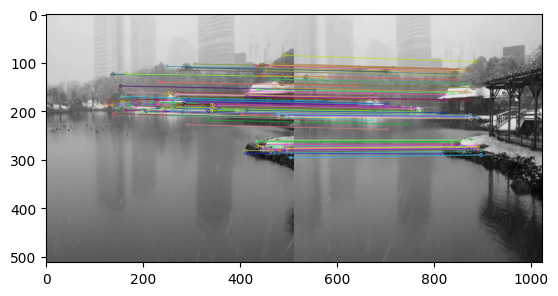

Matched image saved as output_matched_image.jpg
Optimization complete.


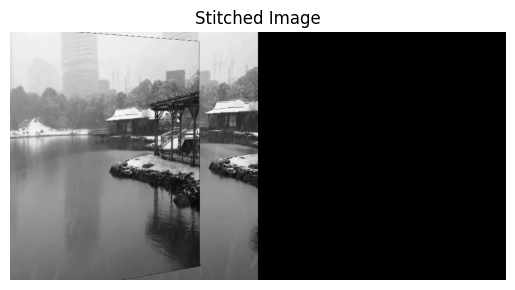

In [ ]:
def main():
    # サンプル画像を読み込む（データセットから連続した番号の画像を使う）
    img1 = cv2.imread("/000032.jpg", cv2.IMREAD_GRAYSCALE)
    img2 = cv2.imread("/000033.jpg", cv2.IMREAD_GRAYSCALE)

    # 画像が正しく読み込まれるようにする
    if img1 is None or img2 is None:
        print("Error: Images not found or path is incorrect.")
        return

    # ステップ1：オーバーラップ率の推定
    overlap_ratio = overlap_ratio_calculation(img1, img2, R=6378000, h=100, f=35, pixel_size=0.01,
                                              row=1080, col=1920, lat1=35.6895, lon1=139.6917,
                                              lat2=35.6896, lon2=139.6918, uav_pos=30
                                             )

    # ステップ2：フィーチャーマッチング
    keypoints1, keypoints2, matches, H = feature_matching(img1, img2)
    if not matches:
        print("No matches found.")
        return

    # ステップ3：頂点位置の最適化（OP-GSPモデル）
    match_weights = [1.0 for _ in matches]
    initial_guess = np.array([keypoint.pt for keypoint in keypoints1]).flatten()

    # 結果を表示する
    print(f"Number of matches: {len(matches)}")

    # マッチしたキーポイントを描画して保存する
    matched_img = draw_matched_keypoints(img1, keypoints1, img2, keypoints2, matches)
    plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
    plt.show()

    cv2.imwrite("output_matched_image.jpg", matched_img)
    print("Matched image saved as output_matched_image.jpg")
    print("Optimization complete.")

    stitched_image = combine_images(img1, img2, H)
    if stitched_image is None:
        print("Image stitching failed.")
        return

    # つなぎ合わせた画像の表示と保存
    plt.imshow(stitched_image, cmap="gray")
    plt.title("Stitched Image")
    plt.axis("off")
    plt.show()

if __name__ == "__main__":
    main()
